# Coursework 3: RNNs

#### Instructions

Please submit on CATe a zip file named *CW3_RNNs.zip* containing a version of this notebook with your answers. Write your answers in the cells below for each question.


## Recurrent models coursework

This coursework is separated into a coding and a theory component.

For the first part, you will use the Google Speech Commands v0.02 subset that you used in the RNN tutorial: http://www.doc.ic.ac.uk/~pam213/co460_files/ 

### Part 1 - Coding
In this part you will have to:

- Implement an LSTM
- Implement a GRU

### Part 2 - Theory

Here you will answer some theoretical questions about RNNs -- no detailed proofs and no programming.

### Part 1: Coding

### Dataset

We will be using the Google [*Speech Commands*](https://www.tensorflow.org/tutorials/sequences/audio_recognition) v0.02 [1] dataset.

[1] Warden, P. (2018). [Speech commands: A dataset for limited-vocabulary speech recognition](https://arxiv.org/abs/1804.03209). *arXiv preprint arXiv:1804.03209.*

In [4]:
## MAKE SURE THIS POINTS INSIDE THE DATASET FOLDER.
dataset_folder = "" # this should change depending on where you have stored the data files

### Initial code before coursework questions start:

In [5]:
import math
import os
import random
from collections import defaultdict

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset
import numpy as np
from scipy.io.wavfile import read
import librosa
from matplotlib import pyplot as plt

cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor


In [6]:
def set_seed(seed_value):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

set_seed(42)

In [7]:
class SpeechCommandsDataset(Dataset):
    """Google Speech Commands dataset."""

    def __init__(self, root_dir, split):
        """
        Args:
            root_dir (string): Directory with all the data files.
            split    (string): In ["train", "valid", "test"].
        """
        self.root_dir = root_dir
        self.split = split

        self.number_of_classes = len(self.get_classes())

        self.class_to_file = defaultdict(list)

        self.valid_filenames = self.get_valid_filenames()
        self.test_filenames = self.get_test_filenames()

        for c in self.get_classes():
            file_name_list = sorted(os.listdir(self.root_dir + "data_speech_commands_v0.02/" + c))
            for filename in file_name_list:
                if split == "train":
                    if (filename not in self.valid_filenames[c]) and (filename not in self.test_filenames[c]):
                        self.class_to_file[c].append(filename)
                elif split == "valid":
                    if filename in self.valid_filenames[c]:
                        self.class_to_file[c].append(filename)
                elif split == "test":
                    if filename in self.test_filenames[c]:
                        self.class_to_file[c].append(filename)
                else:
                    raise ValueError("Invalid split name.")

        self.filepath_list = list()
        self.label_list = list()
        for cc, c in enumerate(self.get_classes()):
            f_extension = sorted(list(self.class_to_file[c]))
            l_extension = [cc for i in f_extension]
            f_extension = [self.root_dir + "data_speech_commands_v0.02/" + c + "/" + filename for filename in f_extension]
            self.filepath_list.extend(f_extension)
            self.label_list.extend(l_extension)
        self.number_of_samples = len(self.filepath_list)

    def __len__(self):
        return self.number_of_samples

    def __getitem__(self, idx):
        sample = np.zeros((16000, ), dtype=np.float32)

        sample_file = self.filepath_list[idx]

        sample_from_file = read(sample_file)[1]
        sample[:sample_from_file.size] = sample_from_file
        sample = sample.reshape((16000, ))
        
        sample = librosa.feature.mfcc(y=sample, sr=16000, hop_length=512, n_fft=2048).transpose().astype(np.float32)

        label = self.label_list[idx]

        return sample, label

    def get_classes(self):
        return ['one', 'two', 'three']

    def get_valid_filenames(self):
        class_names = self.get_classes()

        class_to_filename = defaultdict(set)
        with open(self.root_dir + "data_speech_commands_v0.02/validation_list.txt", "r") as fp:
            for line in fp:
                clean_line = line.strip().split("/")

                if clean_line[0] in class_names:
                    class_to_filename[clean_line[0]].add(clean_line[1])

        return class_to_filename

    def get_test_filenames(self):
        class_names = self.get_classes()

        class_to_filename = defaultdict(set)
        with open(self.root_dir + "data_speech_commands_v0.02/testing_list.txt", "r") as fp:
            for line in fp:
                clean_line = line.strip().split("/")

                if clean_line[0] in class_names:
                    class_to_filename[clean_line[0]].add(clean_line[1])

        return class_to_filename

In [8]:

train_dataset = SpeechCommandsDataset(dataset_folder,
                                      "train")
valid_dataset = SpeechCommandsDataset(dataset_folder,
                                      "valid")

test_dataset = SpeechCommandsDataset(dataset_folder,
                                     "test")

batch_size = 100


num_epochs = 5
valid_every_n_steps = 20
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

### Question 1:  Finalise the LSTM and GRU cells by completing the missing code

You are allowed to use nn.Linear.

In [41]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        
        ########################################################################
        ## START OF YOUR CODE - Question 1a) Complete the missing code
        ########################################################################

        self.x2h = nn.Linear(input_size, 4 * hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 4 * hidden_size, bias=bias)
        self.c2c = Tensor(hidden_size * 3)
        self.tanh = nn.Tanh()
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)
            hx = (hx, hx)
            
        # We used hx to pack both the hidden and cell states
        hx, cx = hx
        
        ########################################################################
        ## START OF YOUR CODE - Question 1b) Complete the missing code
        ########################################################################
        input = input.view(-1, input.size(1))
        
        gates = self.x2h(input) + self.h2h(hx)
    
        gates = gates.squeeze()
        
        c2c = self.c2c.unsqueeze(0)
        ci, cf, co = c2c.chunk(3,1)
        in_gate, forget_gate, new_memory, out_gate = gates.chunk(4, 1)
        
        in_gate = torch.sigmoid(in_gate+ ci * cx)
        forget_gate = torch.sigmoid(forget_gate + cf * cx)
        cy = forget_gate*cx + in_gate* self.tanh(new_memory)
        out_gate = torch.sigmoid(out_gate+ co*cy)
        

        hy = out_gate * self.tanh(cy)
        
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################

        return (hy, cy)

class BasicRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True, nonlinearity="tanh"):
        super(BasicRNNCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.nonlinearity = nonlinearity
        if self.nonlinearity not in ["tanh", "relu"]:
            raise ValueError("Invalid nonlinearity selected for RNN.")

        self.x2h = nn.Linear(input_size, hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, hidden_size, bias=bias)

        self.reset_parameters()
        

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

            
    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)

        activation = getattr(nn.functional, self.nonlinearity)
        hy = activation(self.x2h(input) + self.h2h(hx))

        return hy

    
    
class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        ########################################################################
        ## START OF YOUR CODE - Question 1c) Complete the missing code
        ########################################################################
        # self.x2h = nn.Linear(input_size, hidden_size, bias=bias)
        # self.h2h = nn.Linear(hidden_size, hidden_size, bias=bias)

        # # self.x2r = 
        # # self.h2r =

        # reset gate components
        self.linear_reset_w1 = nn.Linear(self.input_size, self.hidden_size, bias=True)
        self.linear_reset_r1 = nn.Linear(self.hidden_size, self.hidden_size, bias=True)

        self.linear_reset_w2 = nn.Linear(self.input_size, self.hidden_size, bias=True)
        self.linear_reset_r2 = nn.Linear(self.hidden_size, self.hidden_size, bias=True)
        self.activation_1 = nn.Sigmoid()

        # update gate components
        self.linear_gate_w3 = nn.Linear(self.input_size, self.hidden_size, bias=True)
        self.linear_gate_r3 = nn.Linear(self.hidden_size, self.hidden_size, bias=True)
        self.activation_2 = nn.Sigmoid()

        self.activation_3 = nn.Tanh()
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        self.reset_parameters()
        

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):
        if hx is None:
            hx = input.new_zeros(input.size(0), self.hidden_size, requires_grad=False)

        ########################################################################
        ## START OF YOUR CODE - Question 1d) Complete the missing code
        ########################################################################
        # gate reset
        x_1 = self.linear_reset_w1(input)
        h_1 = self.linear_reset_r1(hx)
        
        r = self.activation_1(x_1 + h_1)

        # gate update
        x_2 = self.linear_reset_w2(input)
        h_2 = self.linear_reset_r2(hx)
        z = self.activation_2(h_2 + x_2)


        # update component
        x_3 = self.linear_gate_w3(input)
        h_3 = r * self.linear_gate_r3(hx)
        n = self.activation_3(x_3 + h_3)


        hy = (1 - z) * n + z * hx
        
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        
        return hy

### Question 2:  Finalise the RNNModel and BidirRecurrentModel

Note that there are serveral different ways that one can implement a bi-directional recurrent neural network. Specifically in this coursework we ask for implementation of the following type of architecture (with e.g. 2 layers for each direction as an example, your implementation should work for any number of layers):

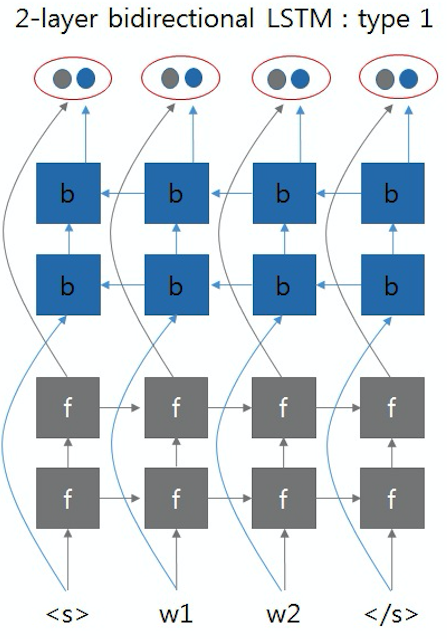

In [1]:
from IPython.display import Image, display
display(Image(filename='bidirectional_rnn_arch.png', width=300))

In [36]:
class RNNModel(nn.Module):
    def __init__(self, mode, input_size, hidden_size, num_layers, bias, output_size):
        super(RNNModel, self).__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size
        
        self.rnn_cell_list = nn.ModuleList()
        
        if mode == 'LSTM':
        ########################################################################
        ## START OF YOUR CODE - Question 2a) Complete the missing code
        #
        #  Append the appropriate LSTM cells to rnn_cell_list
        ########################################################################
            self.rnn_cell_list.append(LSTMCell(self.input_size,
                                                self.hidden_size,
                                                self.bias))
            for _ in range(1, self.num_layers):
                self.rnn_cell_list.append(LSTMCell(self.hidden_size,
                                                    self.hidden_size,
                                                    self.bias))
                
        ########################################################################
        ## END OF YOUR CODE
        ######################################################################## 

        elif mode == 'GRU':
            
        ########################################################################
        ## START OF YOUR CODE - Question 2b) Complete the missing code
        #
        #  Append the appropriate GRU cells to rnn_cell_list
        ########################################################################
            self.rnn_cell_list.append(GRUCell(self.input_size,
                                          self.hidden_size,
                                          self.bias))
            for _ in range(1, self.num_layers):
                self.rnn_cell_list.append(GRUCell(self.hidden_size,
                                                self.hidden_size,
                                                self.bias))

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################        
        
        elif mode == 'RNN_TANH':
            
                    
        ########################################################################
        ## START OF YOUR CODE - Question 2c) Complete the missing code
        #
        #  Append the appropriate RNN cells to rnn_cell_list
        ########################################################################
            self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "tanh"))
            for _ in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                       self.hidden_size,
                                                       self.bias,
                                                       "tanh"))

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################


                
        elif mode == 'RNN_RELU':
            
        ########################################################################
        ## START OF YOUR CODE - Question 2d) Complete the missing code
        #
        #  Append the appropriate RNN cells to rnn_cell_list
        ########################################################################
            self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
            for _ in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))

        ########################################################################
        ## END OF YOUR CODE
        ########################################################################


        else:
            raise ValueError("Invalid RNN mode selected.")


        self.att_fc = nn.Linear(self.hidden_size, 1)
        self.fc = nn.Linear(self.hidden_size, self.output_size)

        
    def forward(self, input, hx=None):

        outs = []
        # h0 = [None] * self.num_layers if hx is None else list(hx)

        
        # In this forward pass we want to create our RNN from the rnn cells,
        # ..taking the hidden states from the final RNN layer and passing these 
        # ..through our fully connected layer (fc).
        
        # The multi-layered RNN should be able to run when the mode is either 
        # .. LSTM, GRU, RNN_TANH or RNN_RELU.
        
        ########################################################################
        ## START OF YOUR CODE - Question 2e) Complete the missing code
        #
        #  HINT: You may need a special case for LSTMs
        ########################################################################
        if torch.cuda.is_available():
            h0 = input.new_zeros(self.num_layers, input.size(0), self.hidden_size).cuda()
        else:
            h0 = input.new_zeros(self.num_layers, input.size(0), self.hidden_size)

        hidden = list()

        if self.mode == 'LSTM':
            for layer in range(self.num_layers):
                hidden.append((h0[layer, :, :], h0[layer, :, :]))

            for t in range(input.size(1)):

                for layer in range(self.num_layers):

                    if layer == 0:
                        hidden_l = self.rnn_cell_list[layer](
                            input[:, t, :],
                            (hidden[layer][0],hidden[layer][1])
                            )
                    else:
                        hidden_l = self.rnn_cell_list[layer](
                            hidden[layer - 1][0],
                            (hidden[layer][0], hidden[layer][1])
                            )

                    hidden[layer] = hidden_l

                outs.append(hidden_l[0])
        else:

            for layer in range(self.num_layers):
                hidden.append(h0[layer, :, :])

            for t in range(input.size(1)):

                for layer in range(self.num_layers):

                    if layer == 0:
                        hidden_l = self.rnn_cell_list[layer](input[:, t, :], hidden[layer])
                    else:
                        hidden_l = self.rnn_cell_list[layer](hidden[layer - 1],hidden[layer])
                    hidden[layer] = hidden_l

                    hidden[layer] = hidden_l

                outs.append(hidden_l)
    
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################

        out = outs[-1].squeeze()

        out = self.fc(out)
        
        
        return out
    

class BidirRecurrentModel(nn.Module):
    def __init__(self, mode, input_size, hidden_size, num_layers, bias, output_size):
        super(BidirRecurrentModel, self).__init__()
        self.mode = mode
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size
        
        self.rnn_cell_list = nn.ModuleList()
        self.rnn_cell_list_rev = nn.ModuleList()
        
        ########################################################################
        ## START OF YOUR CODE - Question 2f) Complete the missing code
        #
        #  Create code for the following 'mode' values:
        # 'LSTM', 'GRU', 'RNN_TANH' and 'RNN_RELU'
        ########################################################################
        if mode == 'LSTM':

            self.rnn_cell_list.append(LSTMCell(self.input_size,
                                              self.hidden_size,
                                              self.bias))
            for _ in range(1, self.num_layers):
                self.rnn_cell_list.append(LSTMCell(self.hidden_size,
                                                    self.hidden_size,
                                                    self.bias))

        elif mode == 'GRU':
            self.rnn_cell_list.append(GRUCell(self.input_size,
                                              self.hidden_size,
                                              self.bias))
            for _ in range(1, self.num_layers):
                self.rnn_cell_list.append(GRUCell(self.hidden_size,
                                                  self.hidden_size,
                                                  self.bias))

        elif mode == 'RNN_TANH':
            self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "tanh"))
            for _ in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                       self.hidden_size,
                                                       self.bias,
                                                       "tanh"))

        elif mode == 'RNN_RELU':
            self.rnn_cell_list.append(BasicRNNCell(self.input_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))
            for _ in range(1, self.num_layers):
                self.rnn_cell_list.append(BasicRNNCell(self.hidden_size,
                                                   self.hidden_size,
                                                   self.bias,
                                                   "relu"))

        self.fc = nn.Linear(self.hidden_size * 2, self.output_size)
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################
        
        
    def forward(self, input, hx=None):
        
        # In this forward pass we want to create our Bidirectional RNN from the rnn cells,
        # .. taking the hidden states from the final RNN layer with their reversed counterparts
        # .. before concatening these and running them through the fully connected layer (fc)
        
        # The multi-layered RNN should be able to run when the mode is either 
        # .. LSTM, GRU, RNN_TANH or RNN_RELU.
        
        ########################################################################
        ## START OF YOUR CODE  - Question 2g) Complete the missing code
        ########################################################################
        outs = []
        outs_rev = []
        if torch.cuda.is_available():
            h0 = input.new_zeros(self.num_layers, input.size(0), self.hidden_size, requires_grad=False).cuda()
        else:
            h0 = input.new_zeros(self.num_layers, input.size(0), self.hidden_size, requires_grad=False)
        
        if torch.cuda.is_available():
            hT = input.new_zeros(self.num_layers, input.size(0), self.hidden_size, requires_grad=False).cuda()
        else:
            hT = input.new_zeros(self.num_layers, input.size(0), self.hidden_size, requires_grad=False)

        hidden_forward = list()
        for layer in range(self.num_layers):
            if self.mode == 'LSTM':
                hidden_forward.append((h0[layer, :, :], h0[layer, :, :]))
            else:
                hidden_forward.append(h0[layer, :, :])

        hidden_backward = list()
        for layer in range(self.num_layers):
            if self.mode == 'LSTM':
                hidden_backward.append((hT[layer, :, :], hT[layer, :, :]))
            else:
                hidden_backward.append(hT[layer, :, :])

        for t in range(input.shape[1]):
            for layer in range(self.num_layers):

                if self.mode == 'LSTM':
                    # If LSTM
                    if layer == 0:
                        # Forward net
                        h_forward_l = self.rnn_cell_list[layer](
                            input[:, t, :],
                            (hidden_forward[layer][0], hidden_forward[layer][1])
                            )
                        # Backward net
                        h_back_l = self.rnn_cell_list[layer](
                            input[:, -(t + 1), :],
                            (hidden_backward[layer][0], hidden_backward[layer][1])
                            )
                    else:
                        # Forward net
                        h_forward_l = self.rnn_cell_list[layer](
                            hidden_forward[layer - 1][0],
                            (hidden_forward[layer][0], hidden_forward[layer][1])
                            )
                        # Backward net
                        h_back_l = self.rnn_cell_list[layer](
                            hidden_backward[layer - 1][0],
                            (hidden_backward[layer][0], hidden_backward[layer][1])
                            )

                else:
                    # If RNN{_TANH/_RELU} / GRU
                    if layer == 0:
                        # Forward net
                        h_forward_l = self.rnn_cell_list[layer](input[:, t, :], hidden_forward[layer])
                        # Backward net
                        h_back_l = self.rnn_cell_list[layer](input[:, -(t + 1), :], hidden_backward[layer])
                    else:
                        # Forward net
                        h_forward_l = self.rnn_cell_list[layer](hidden_forward[layer - 1], hidden_forward[layer])
                        # Backward net
                        h_back_l = self.rnn_cell_list[layer](hidden_backward[layer - 1], hidden_backward[layer])


                hidden_forward[layer] = h_forward_l
                hidden_backward[layer] = h_back_l

            if self.mode == 'LSTM':

                outs.append(h_forward_l[0])
                outs_rev.append(h_back_l[0])

            else:
                outs.append(h_forward_l)
                outs_rev.append(h_back_l)
        
        ########################################################################
        ## END OF YOUR CODE
        ########################################################################

        out = outs[-1].squeeze()
        out_rev = outs_rev[0].squeeze()
        out = torch.cat((out, out_rev), 1)
        out = self.fc(out)
        return out

The code below trains a network based on your code above. This should work without error:

In [42]:

seq_dim, input_dim = train_dataset[0][0].shape
output_dim = 3

hidden_dim = 32
layer_dim = 1
bias = True

### Change the code below to try running different models:
model = RNNModel("GRU", input_dim, hidden_dim, layer_dim, bias, output_dim)
# model = BidirRecurrentModel("LSTM", input_dim, hidden_dim, layer_dim, bias, output_dim)

if torch.cuda.is_available():
    model.cuda()
    
criterion = nn.CrossEntropyLoss()

learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss_list = []
iter = 0
max_v_accuracy = 0
reported_t_accuracy = 0
max_t_accuracy = 0
for epoch in range(num_epochs):
    for i, (audio, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
            labels = Variable(labels.cuda())
        else:
            audio = Variable(audio.view(-1, seq_dim, input_dim))
            labels = Variable(labels)

        optimizer.zero_grad()
        # print(torch.cuda.get_device_name(torch.cuda.current_device()), audio.is_cuda)

        outputs = model(audio)
        
        loss = criterion(outputs, labels)

        if torch.cuda.is_available():
            loss.cuda()

        loss.backward()

        optimizer.step()

        loss_list.append(loss.item())
        iter += 1

        if iter % valid_every_n_steps == 0:
            correct = 0
            total = 0
            for audio, labels in valid_loader:
                if torch.cuda.is_available():
                    audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                else:
                    audio = Variable(audio.view(-1, seq_dim, input_dim))

                outputs = model(audio)

                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            v_accuracy = 100 * correct // total
            
            is_best = False
            if v_accuracy >= max_v_accuracy:
                max_v_accuracy = v_accuracy
                is_best = True

            if is_best:
                for audio, labels in test_loader:
                    if torch.cuda.is_available():
                        audio = Variable(audio.view(-1, seq_dim, input_dim).cuda())
                    else:
                        audio = Variable(audio.view(-1, seq_dim, input_dim))

                    outputs = model(audio)

                    _, predicted = torch.max(outputs.data, 1)

                    total += labels.size(0)

                    if torch.cuda.is_available():
                        correct += (predicted.cpu() == labels.cpu()).sum()
                    else:
                        correct += (predicted == labels).sum()

                t_accuracy = 100 * correct // total
                reported_t_accuracy = t_accuracy

            print('Iteration: {}. Loss: {}. V-Accuracy: {}  T-Accuracy: {}'.format(iter, loss.item(), v_accuracy, reported_t_accuracy))



/tmp/ipykernel_718674/1136179928.py:71: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  v_accuracy = 100 * correct // total
/tmp/ipykernel_718674/1136179928.py:96: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  t_accuracy = 100 * correct // total


Iteration: 20. Loss: 1.0325318574905396. V-Accuracy: 57  T-Accuracy: 57
Iteration: 40. Loss: 0.9664454460144043. V-Accuracy: 56  T-Accuracy: 57
Iteration: 60. Loss: 0.8289366364479065. V-Accuracy: 65  T-Accuracy: 62
Iteration: 80. Loss: 0.8505355715751648. V-Accuracy: 67  T-Accuracy: 64
Iteration: 100. Loss: 0.7762539386749268. V-Accuracy: 63  T-Accuracy: 64
Iteration: 120. Loss: 0.7671914100646973. V-Accuracy: 57  T-Accuracy: 64
Iteration: 140. Loss: 0.7952094078063965. V-Accuracy: 66  T-Accuracy: 64
Iteration: 160. Loss: 0.6988388895988464. V-Accuracy: 58  T-Accuracy: 64
Iteration: 180. Loss: 0.8210386633872986. V-Accuracy: 58  T-Accuracy: 64
Iteration: 200. Loss: 0.6574717164039612. V-Accuracy: 59  T-Accuracy: 64
Iteration: 220. Loss: 0.7298939228057861. V-Accuracy: 63  T-Accuracy: 64
Iteration: 240. Loss: 0.6829645037651062. V-Accuracy: 63  T-Accuracy: 64
Iteration: 260. Loss: 0.7687949538230896. V-Accuracy: 64  T-Accuracy: 64
Iteration: 280. Loss: 0.734449028968811. V-Accuracy: 61

## Part 2: Theoretical questions

#### Theory question 1: 
What is the _vanishing gradients problem_ and why does it occur? Which activation functions are more or less impacted by this, and why?

#### Your answers:
* Your answer here describing vanishing gradients problem

As the backpropagation algorithm propagates backward from the output layer towards the input layer, the gradients involved have the tendency to get smaller and smaller and approach zero; this has the consequence of leaveing the weights of the initial or lower layers effectively unchanged. As a result of the vanishing gradients, the gradient descent may never end up converging to the optimum. 


* Two examples of activation functions more impacted by vanishing gradients
The sigmoid function is the most common exmaple given when talking about the vanishing gradient problem. As it collapses a large input space into a small input space of 0 to 1, large changes in the input of the sigmoid function only cause small changes in the output, therefore the derivative becomes very small. 

Any of the hyperbolic tangent functions with gradients in the range [0,1] will suffer from this problem, so another example of an activation function that suffers from the vanishing gradient problem is the tanh function.


* Two examples of activation functions less impacted by vanishing gradients, why are they impacted less?
The most common solution to the vaninishing gradient problem is to use the ReLU activation function. The ReLu function is a non-saturating activation function - having outputs in the range of [0, infinity] - so does not produce the small derivatives which cause the vanishing gradients. ReLu has its own problem known as dying ReLus, where neurons die out and simple remain 0s as training advances. The solution to this is to use alternative ReLu functions, the most common being the LReLU (Leaky ReLU) activation function, which maintains a small slope (leak) for negative values (which would simply be 0 for the ReLu).



#### Theory question 2: 
Why do LSTMs help address the vanishing gradient problem compared to a vanilla RNN?

#### Theory question 3: 

The plot below shows the training curves for three models A, B, and C, trained on the same dataset up to 100 epochs. The three models are a RNN, a LSTM and a GRU, not necessarily in that order.

* Which could plausibly be which? Why? Please explain your reasoning.

(In the cell below please set the values for A_model, B_model and C_model to be 'RNN', 'LSTM' or 'GRU'. This needs to be exact for the automatic marking.)

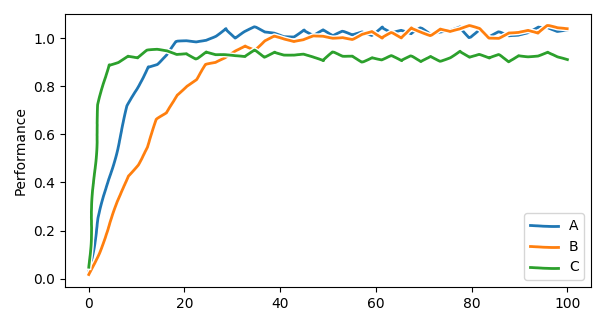

In [2]:
from IPython.display import Image, display
display(Image(filename='Performance by epoch.png', width=550))

In [ ]:
# Answers below:

A_model = ''
B_model = ''
C_model = ''

# Give your reasons below:



#### Theory question 4: 

When might you choose to use each of the three different types of models?

#### Your answers:
* Type of problem when best to use vanilla RNN:
* Type of problem to use GRU:
* Type of problem to use LSTM:
